<a href="https://colab.research.google.com/github/coldsober-irene/ASSIGNMENTS/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import block_diag


In [21]:
%%capture
!pip install control


In [22]:
# System parameters and simulation parameters
A = np.array([[0.9638, 0.0162], [0.0162, 0.9627]])  # System matrix
B = np.array([[0.0031, 0], [0, 0.0031]])  # Input matrix
C = np.eye(2)
Np = 50  # Prediction horizon
Nc = 10

#discretization

In [23]:
import numpy as np
import control

def c2d(Ac = np.array([[-0.370, 0.168], [0.168, -0.38]]),
    Bc = np.array([[0.03125, 0], [0, 0.03125]]),
    Cc = np.array([[1, 0], [0, 1]]),
    Dc = np.array([[0, 0], [0, 0]]),
    Ts = 0.1):

    # Create a state-space system
    sys_continuous = control.ss(Ac, Bc, Cc, Dc)
    # Discretize the system
    sys_discrete = sys_continuous.sample(Ts, method='zoh')

    # The discretized system matrices can be accessed as follows:
    Ad = sys_discrete.A
    Bd = sys_discrete.B
    Cd = sys_discrete.C
    Dd = sys_discrete.D
    return Ad, Bd, Cd, Dd

def Augment(Ad, Bd, Cd):
  # Get the sizes
  row1, col1 = Cd.shape
  d, cb = Bd.shape

  # Create the augmented matrices
  A = np.eye(col1 + row1)
  A[:col1, :d] = Ad
  A[:col1, col1:col1 + row1] = Bd

  B = np.zeros((col1 + row1, cb))
  B[:col1, :] = Bd
  B[col1:col1 + d, :] = np.eye(d)

  C = np.zeros((row1, col1 + row1))
  C[:, :col1] = Cd
  return A, B, C

$Y = Fx(k_i) + \Phi \Delta U $

computing $F$ and $\Phi$

In [24]:
Ad, Bd, Cd, _ = c2d()
A, B, C = Augment(Ad, Bd, Cd)
Np = 10

In [25]:
def ComputeF_Phi(A, B, C, Np):

  """A,B,C are the auPhimented matrices
     Np prediction horizon Np > 8
  """
  # Compute the sizes
  F_r, F_c = np.shape(np.dot(C, A))

  # Initialize F
  F = np.zeros((Np*F_r, F_c))

  # First row of F
  F[:F_r, :] = np.dot(C, A)

  # Compute the remaininPhi rows of F
  for k in range(F_r, Np*F_r, F_r):
      F[k:k+F_r, :] = np.dot(F[k-F_r:k, :], A)

  # Compute the sizes
  Phi_r, Phi_c = np.shape(np.dot(C, B))

  # Initialize Phi
  Phi = np.zeros((Np*Phi_r, Nc*Phi_c))

  # First row of Phi
  Phi[:Phi_r, :Phi_c] = np.dot(C, B)

  # Compute the remaininPhi rows of Phi
  for k in range(Phi_r, Np*Phi_r, Phi_r):
      p = (k - Phi_r) // Phi_r + 1
      Phi[k:k+Phi_r, :Phi_c] = np.dot(C, np.linalg.matrix_power(A, p).dot(B))

  # Shift the columns of Phi
  for k in range(Phi_c, Nc*Phi_c, Phi_c):
      shift = Phi_r * (k - Phi_c) // Phi_c + Phi_r
      Phi[:, k:k+Phi_c] = np.roll(Phi[:, :Phi_c], shift)
      Phi[:shift, k:k+Phi_c] = np.zeros((shift, Phi_c))
  return F, Phi

In [26]:
F, Phi = ComputeF_Phi(A, B, C, Np = 10)
Phi

array([[3.06803692e-03, 2.56034866e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.56034866e-05, 3.06651290e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.02546232e-03, 9.99040611e-05, 2.56034866e-05, 3.06651290e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000

#MPC implementation ↓

In [27]:
!pip install quadprog
!pip install qpsolvers

In [ ]:
import numpy as np
from scipy.optimize import minimize
from quadprog import solve_qp
from qpsolvers import Problem, solve_problem

# Assuming A, B, C, D, Np, Nc, ref_1, ref_2, G, phi, x(k), lambda_, I are already defined
# Compute the sizes
Nc = 10
S2 = np.zeros((2*Nc, 2*Nc))

for p in range(0, 2*Nc, 2):
    for q in range(0, p+2, 2):
        S2[p:p+2, q:q+2] = np.eye(2)

# S1 matrix calculation
# S1 = []
# for k in range(0, 2*Nc, 2):
#     S1 = np.vstack((S1, np.eye(2)))
S1 = np.empty((0, 2))

for k in range(0, 2*Nc, 2):
    S1 = np.vstack((S1, np.eye(2)))
# Initialize sensor readings
# sampling_rate = 30
# samples_trigger = 30
# Assuming sensor_reading_volts and conversion_reg are already defined
# sensordata = sensor_reading_volts(sampling_rate, samples_trigger)
# sensordata = np.mean(sensordata[20:30, :])
# converted_value_tank1 = conversion_reg(sensordata[0], 1, 0, 3)
# converted_value_tank2 = conversion_reg(sensordata[1], 1, 2, 3)
H1_initial = 2.5
H2_initial = 3.2
ref_1 = 18 # cm
ref_2 = 15 # cm
lambda_ = 3.5
Xm = np.array([H1_initial, H2_initial])

# Initialize plant
Uplant = np.array([1.5, 3.5])
Yplant = np.array([H1_initial, H2_initial])
Uk = Uplant
Yk = Yplant

# Initialize data
U1data = []
Y1data = []
U2data = []
Y2data = []
Xdata = []
ref_1data = []
ref_2data = []
tdata = []

# Initialize constraints
U_min = np.zeros(2*Nc)
U_max = 35*np.ones(2*Nc)
deltaU_min = -0.5*np.ones(2*Nc)
deltaU_max = 1.5*np.ones(2*Nc)
Y_min1 = np.zeros(Np)
Y_min2 = np.zeros(Np)
Y_min = np.zeros(2*Np)
for ay in range(0, 2*Np, 2):
    Y_min[ay] = Y_min1[ay//2]
for ax in range(1, 2*Np, 2):
    Y_min[ax] = Y_min2[ax//2]
Y_max1 = (ref_1+1)*np.ones(Np)
Y_max2 = (ref_2+1)*np.ones(Np)
Y_max = np.zeros(2*Np)
for by in range(0, 2*Np, 2):
    Y_max[by] = Y_max1[by//2]
for bx in range(1, 2*Np, 2):
    Y_max[bx] = Y_max2[bx//2]

# Reference output trajectory
R1 = ref_1*np.ones(Np)
R2 = ref_2*np.ones(Np)
R = np.zeros(2*Np)
for cy in range(0, 2*Np, 2):
    R[cy] = R1[cy//2]
for cx in range(1, 2*Np, 2):
    R[cx] = R2[cx//2]

# Initial state vector
Ef = np.array([0, 0, H1_initial, H2_initial])
print(f"Ef: {Ef}")
Ref_1 = ref_1  # reference output
Ref_2 = ref_2  # reference output
I = np.eye(2*Nc)

# J matrix formulation
J = np.vstack((-S2, S2, -I, I, -Phi, Phi))

# Q matrix formulation
# Q = np.dot(Phi.T, Phi) + lambda_*np.eye(np.shape(np.dot(Phi.T, Phi)))
Q = np.dot(Phi.T, Phi) + lambda_ * np.eye(np.shape(np.dot(Phi.T, Phi))[0])


# Iteration
iter_start = 1
iter_end = 180
for k in range(iter_start, iter_end+1):
    g = np.concatenate((-U_min + np.dot(S1, Uk), U_max - np.dot(S1, Uk),
                        -deltaU_min, deltaU_max, np.dot(F, Ef) - Y_min, -np.dot(F, Ef) + Y_max))
    c = np.dot(Phi.T, np.dot(F, Ef) - R)
    # c = Phi.T @ ((F @ Ef) - R)
    # print("C    .......")
    # print(c, len(c))
    # print('Q : ', Q.shape)
    # OPTIMIZATION
    problem = Problem(Q, c, J, g)
    delta_U = solve_problem(problem, solver="quadprog")
    # delta_U = solve_qp(Q,c, J, g)
    solution = delta_U.x
    Uapplied = solution[:2]
    Uplant = Uplant + Uapplied
    Uk = Uplant

    # Introducing constant input disturbance in motor 1
    if 90 <= k <= 105:
        Uk_output = Uplant + np.array([-1.0, 0.0])
    # Introducing constant input disturbance in motor 2
    elif 180 <= k <= 195:
        Uk_output = Uplant + np.array([0.0, -2.5])
    else:
        Uk_output = Uplant

    tank1data = Uk_output[0]
    tank2data = Uk_output[1]
    print(f"TANK 1: {tank1data}")
    print(f"TANK 1: {tank2data}")
    # ADDED CODES AFTER SUCCESSFUL RUN
    Yk=Xm
    Xm_old = Xm
    # now read new values and update xm and Yplant
    # [sensordata]=sensor_reading_volts(samplingrate,samples_trigger);
    # sensordata=mean(sensordata(21:30,:));
    # [converted_value_tank1]=conversion_reg(sensordata(1,1),1,0,3);
    # [converted_value_tank2]=conversion_reg(sensordata(1,2),1,2,3);
    # Xm = [(converted_value_tank1/10);(converted_value_tank2/10)];
    tdata.append(k-1)
    ref_1data.append(Ref_1)
    ref_2data.append(Ref_2)
    Y1data.append(Yk[0])
    print(f"Yk[0: 1] = {Uk}")
    U1data.append(Uk[0])
    Y2data.append(Yk[1])
    U2data.append(Uk[1])
    Yk = np.dot(F, Ef) + np.dot(Phi, delta_U.x)

    Yplant = Yk[:2]

    l = np.array(Xm-Xm_old)
    Ef = np.concatenate((l, Xm))
    print(f"Ef: {Ef}")
    Ef = Ef.T


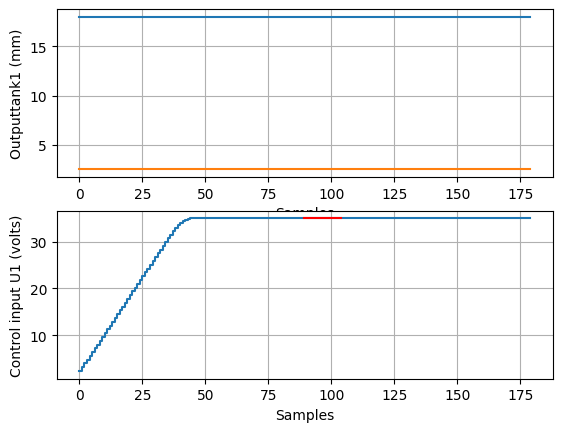

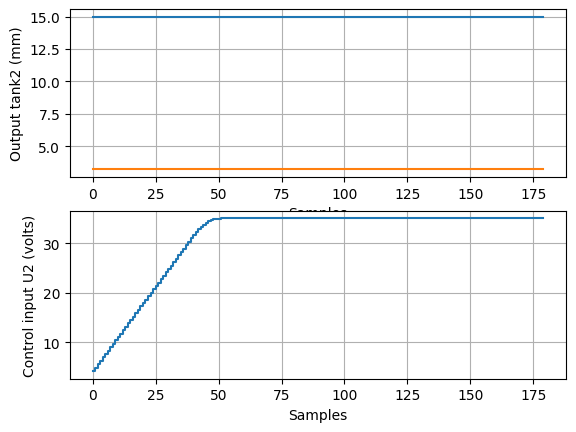

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming tdata, ref_1data, Y1data, U1data, w2data, Y2data, U2data are already defined

# Create first figure
plt.figure()
plt.subplot(211)
plt.plot(tdata, ref_1data, tdata, Y1data)
plt.ylabel('Outputtank1 (mm)')
plt.xlabel('Samples')
plt.grid(True)

plt.subplot(212)
plt.plot(tdata, U1data, drawstyle='steps-post')
plt.plot(tdata[89:105], U1data[89:105], 'r', drawstyle='steps-post')
plt.ylabel('Control input U1 (volts)')
plt.xlabel('Samples')
plt.grid(True)

# Create second figure
plt.figure()
plt.subplot(211)
plt.plot(tdata, ref_2data, tdata, Y2data)
plt.ylabel('Output tank2 (mm)')
plt.xlabel('Samples')
plt.grid(True)

plt.subplot(212)
plt.plot(tdata, U2data, drawstyle='steps-post')
plt.plot(tdata[179:195], U2data[179:195], 'r', drawstyle='steps-post')
plt.ylabel('Control input U2 (volts)')
plt.xlabel('Samples')
plt.grid(True)

plt.show()


#draft ↓

In [ ]:
!pip install qpsolvers

In [54]:
import numpy as np
from qpsolvers import Problem, solve_problem

M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
P = M.T.dot(M)  # quick way to build a symmetric matrix
q = np.array([3., 2., 3.]).dot(M).reshape((3,))
G = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
h = np.array([3., 2., -2.]).reshape((3,))
A = np.array([1., 1., 1.])
b = np.array([1.])
lb = -0.6 * np.ones(3)
ub = +0.7 * np.ones(3)

problem = Problem(P, q, G, h, A, b, lb, ub)
print(f"P: {P.shape}   Q: {Q.shape}  G: {G.shape}")
solution = solve_problem(problem, solver="quadprog")

print(f"- Solution is{'' if solution.is_optimal(1e-8) else ' NOT'} optimal")
print(f"- Primal residual: {solution.primal_residual():.1e}")
print(f"- Dual residual: {solution.dual_residual():.1e}")
print(f"- Duality gap: {solution.duality_gap():.1e}")

P: (3, 3)   Q: (20, 20)  G: (3, 3)
- Solution is optimal
- Primal residual: 1.1e-16
- Dual residual: 1.4e-14
- Duality gap: 0.0e+00


#*Cipher*

In [ ]:
from string import ascii_uppercase, ascii_lowercase

In [ ]:
ijambo = 'irene akunda kwiga'

In [ ]:
def f1(func):
  def show(*x):
    print("Function called: ", func.__name__)
    func(x)

  return show

@f1
def one(x):
  print(f"decorated: {x}")
one(30, 90)

In [ ]:
import numpy as np
from quadprog import solve_qp

# Define the quadratic programming problem in the form:
# min 0.5 * x^T * G * x + a^T * x
# s.t. C * x >= b

G = np.array([[1.0, 0.0], [0.0, 1.0]])  # Objective function quadratic term
a = np.array([0.0, 0.0])                  # Objective function linear term

C = np.array([[1.0, 2.0], [2.0, 1.0]])   # Inequality constraints matrix
b = np.array([3.0, 2.0])                  # Inequality constraints vector

# Solve the quadratic programming problem
x, f, xu, status = solve_qp(G, a, C.T, -b)

# Display the results
print("Solution:", x)
print("Optimal value:", f)
print("Status:", status)


#CLEANING ↓

In [ ]:
Yk=Xm;
Xm_old = Xm;
88

% now read new values and update xm and Yplant
[sensordata]=sensor_reading_volts(samplingrate,samples_trigger);
sensordata=mean(sensordata(21:30,:));
[converted_value_tank1]=conversion_reg(sensordata(1,1),1,0,3);
[converted_value_tank2]=conversion_reg(sensordata(1,2),1,2,3);
Xm = [(converted_value_tank1/10);(converted_value_tank2/10)];
tdata = [tdata; k-1]; wldata = [wldata; w1];w2data = [w2data; w2];
Yldata = [Yldata; Yk(1,1)]; Uldata = [Uldata; Uk(1,1)];
Y2data = [Y2data; Yk(2,1)]; U2data = [U2data; Uk(2,1)];
Yk = (phi'Ef) + (G'deltaJJ);
Yplant = Yk (1:2,1);
Ef=[Xm-Xm_old;Xm];